# Import Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import warnings
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,precision_recall_curve, f1_score
from scipy.stats import ks_2samp
warnings.filterwarnings('ignore', category=FutureWarning)

# Leitura base

In [4]:
df = pd.read_csv('/content/telecom_churn.csv')
df.head()

,id_cliente,churn,genero,cidadao_senior,parceiro,dependentes,tempo_de_contrato,servico_telefone,multiplas_linhas,servico_internet,...,backup_online,protecao_dispositivo,suporte_tecnico,streaming_tv,streaming_filmes,contrato,fatura_sem_papel,metodo_pagamento,total_servicos_mes,total_gasto
0,0002-ORFBO,0,Female,0,1,1,9,1,0.0,DSL,...,1.0,0.0,1.0,1.0,0.0,One year,1,Mailed check,65.6,593.30
1,0003-MKNFE,0,Male,0,0,0,9,1,1.0,DSL,...,0.0,0.0,0.0,0.0,1.0,Month-to-month,0,Mailed check,59.9,542.40
2,0004-TLHLJ,1,Male,0,0,0,4,1,0.0,Fiber optic,...,0.0,1.0,0.0,0.0,0.0,Month-to-month,1,Electronic check,73.9,280.85
3,0011-IGKFF,1,Male,1,1,0,13,1,0.0,Fiber optic,...,1.0,1.0,0.0,1.0,1.0,Month-to-month,1,Electronic check,98.0,1237.85
4,0013-EXCHZ,1,Female,1,1,0,3,1,0.0,Fiber optic,...,0.0,0.0,1.0,1.0,0.0,Month-to-month,1,Mailed check,83.9,267.40


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id_cliente            7043 non-null   object 
 1   churn                 7043 non-null   int64  
 2   genero                7043 non-null   object 
 3   cidadao_senior        7043 non-null   int64  
 4   parceiro              7043 non-null   int64  
 5   dependentes           7043 non-null   int64  
 6   tempo_de_contrato     7043 non-null   int64  
 7   servico_telefone      7043 non-null   int64  
 8   multiplas_linhas      6361 non-null   float64
 9   servico_internet      7043 non-null   object 
 10  seguranca_online      5517 non-null   float64
 11  backup_online         5517 non-null   float64
 12  protecao_dispositivo  5517 non-null   float64
 13  suporte_tecnico       5517 non-null   float64
 14  streaming_tv          5517 non-null   float64
 15  streaming_filmes     

# Exclusão de colunas

**Análise anterior**:

---
**Taxa de Churn:** A empresa possui uma taxa de evasão de 26.54%.


---


**Clientes Recém-Chegados:** O maior pico de churn ocorre nos primeiros meses de contrato, indicando problemas na fase de onboarding.



---


**Contratos Mensais:** Clientes com contratos mensais são o grupo mais propenso à evasão.


---


**Método de Pagamento:** O uso de cheque eletrônico está fortemente associado a um maior churn.


---


**Fatura Digital:** Clientes que optam pela fatura digital tendem a churnar mais.


---


**Gasto Mensal:** Surpreendentemente, clientes com gastos mensais ligeiramente mais altos também mostram maior propensão a cancelar.

**Fatores de Retenção:** A presença de serviços como segurança online e suporte técnico correlaciona-se com menor churn.


---


**Demografia:** Clientes sem parceiro/dependentes e cidadãos seniores são mais suscetíveis ao churn.






In [ ]:
# Função para calcular WOE e IV
def calculate_woe_iv(data, feature, target, bins=10):
    df = data[[feature, target]].copy()

    # Preencher valores nulos temporariamente para manter as categorias separadas
    df[feature] = df[feature].fillna('Missing') if df[feature].dtype == 'O' else df[feature].fillna(-999)

    # Se for numérico, fazer binning
    if pd.api.types.is_numeric_dtype(df[feature]) and df[feature].nunique() > 10:
        df[feature] = pd.qcut(df[feature], bins, duplicates='drop')

    # Criar tabela de frequência
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'bad']
    grouped['good'] = grouped['total'] - grouped['bad']

    # Proporções
    grouped['%bad'] = grouped['bad'] / grouped['bad'].sum()
    grouped['%good'] = grouped['good'] / grouped['good'].sum()

    # WOE e IV
    grouped['woe'] = np.log((grouped['%good'] + 1e-10) / (grouped['%bad'] + 1e-10))
    grouped['iv'] = (grouped['%good'] - grouped['%bad']) * grouped['woe']

    iv = grouped['iv'].sum()
    return iv, grouped[['woe', 'iv']]

# Lista de variáveis (exceto id_cliente e churn)
features = [
    'genero', 'cidadao_senior', 'parceiro', 'dependentes', 'tempo_de_contrato',
    'servico_telefone', 'multiplas_linhas', 'servico_internet', 'seguranca_online',
    'backup_online', 'protecao_dispositivo', 'suporte_tecnico', 'streaming_tv',
    'streaming_filmes', 'contrato', 'fatura_sem_papel', 'metodo_pagamento',
    'total_servicos_mes', 'total_gasto'
]

# Dicionário para armazenar os IVs
iv_dict = {}

# Calcular IV para cada variável
for feature in features:
    try:
        iv, _ = calculate_woe_iv(df, feature, 'churn')
        iv_dict[feature] = iv
    except Exception as e:
        print(f"Erro em {feature}: {e}")

# Exibir ordenado
iv_series = pd.Series(iv_dict).sort_values(ascending=False)
print("Information Value das variáveis:")
print(iv_series)


Information Value das variáveis:
contrato                1.238560
tempo_de_contrato       0.823712
seguranca_online        0.717777
suporte_tecnico         0.699567
servico_internet        0.617953
backup_online           0.528634
protecao_dispositivo    0.499725
metodo_pagamento        0.457109
streaming_filmes        0.381374
streaming_tv            0.380462
total_servicos_mes      0.364717
total_gasto             0.332345
fatura_sem_papel        0.203068
dependentes             0.155488
parceiro                0.118729
cidadao_senior          0.105621
multiplas_linhas        0.008207
servico_telefone        0.000745
genero                  0.000380
dtype: float64


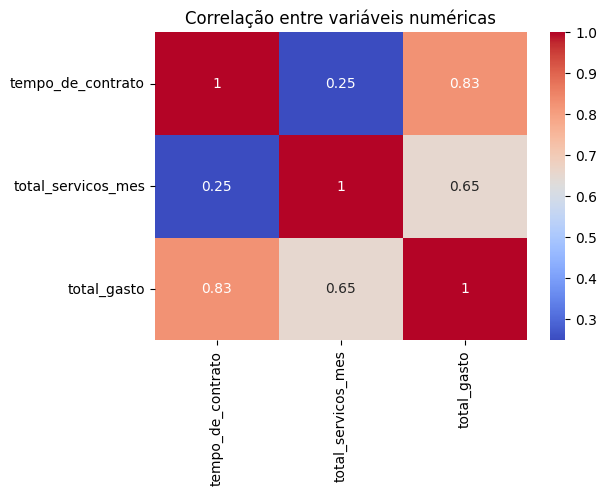

In [ ]:
# Subset das variáveis contínuas
cont_vars = ['tempo_de_contrato', 'total_servicos_mes', 'total_gasto']

# Matriz de correlação
cor_matrix = df[cont_vars].corr()

# Visualização
plt.figure(figsize=(6, 4))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm')
plt.title('Correlação entre variáveis numéricas')
plt.show()


In [ ]:
df_clean = df.drop(['id_cliente','genero','servico_telefone','streaming_tv','streaming_filmes', 'multiplas_linhas', 'total_gasto'], axis=1)
df_clean.head()

,churn,cidadao_senior,parceiro,dependentes,tempo_de_contrato,servico_internet,seguranca_online,backup_online,protecao_dispositivo,suporte_tecnico,contrato,fatura_sem_papel,metodo_pagamento,total_servicos_mes
0,0,0,1,1,9,DSL,0.0,1.0,0.0,1.0,One year,1,Mailed check,65.6
1,0,0,0,0,9,DSL,0.0,0.0,0.0,0.0,Month-to-month,0,Mailed check,59.9
2,1,0,0,0,4,Fiber optic,0.0,0.0,1.0,0.0,Month-to-month,1,Electronic check,73.9
3,1,1,1,0,13,Fiber optic,0.0,1.0,1.0,0.0,Month-to-month,1,Electronic check,98.0
4,1,1,1,0,3,Fiber optic,0.0,0.0,0.0,1.0,Month-to-month,1,Mailed check,83.9


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Padronização das features

In [ ]:
var_bool = ['cidadao_senior',
            'parceiro',
            'dependentes',
            'seguranca_online',
            'backup_online',
            'protecao_dispositivo',
            'suporte_tecnico']

In [ ]:
var_cat = ['servico_internet','contrato','metodo_pagamento']

In [ ]:
var_num = ['tempo_de_contrato','total_servicos_mes']

Tratando Nulls das variávels booleanas, porque modelos como RegLog é sensível a Nan

In [ ]:
for col in var_bool:
    # Preencher NaN com -1 e converter para int
    df_clean[col] = df_clean[col].fillna(-1).astype(int)

Tratando as features numéricas usando o método StandardScaler


In [ ]:
# from sklearn.preprocessing import StandardScaler

# # Suponha que suas variáveis numéricas estão listadas em var_num
# scaler = StandardScaler()

# # Ajusta o scaler nos dados e transforma
# df_clean[var_num] = scaler.fit_transform(df_clean[var_num])

Tratando as features categóricas usando o método OneHotEnconder para 'dummizar' as features

In [ ]:
# one_hot_enc = make_column_transformer(
#     (OneHotEncoder(handle_unknown = 'ignore'),
#     var_cat),
#     remainder='passthrough')
# df_clean = one_hot_enc.fit_transform(df_clean)
# df_clean = pd.DataFrame(df_clean, columns=one_hot_enc.get_feature_names_out())

# # Remove the 'remainder__' prefix from column names
# df_clean.columns = [col.replace('remainder__', '') for col in df_clean.columns]

In [ ]:
df_clean['churn'] = df_clean['churn'].astype(int)

Classe relativamente balanceada. Vou testar balanceando e não balanceando 'churn'


In [ ]:
prop_evasao = df_clean['churn'].value_counts(normalize=True)
print(prop_evasao)

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


# Separação treino e teste

In [ ]:
# X: todas as colunas exceto 'churn'; y: variável alvo
X = df_clean.drop(columns='churn')
y = df_clean['churn']

# Separação com estratificação para manter a proporção da variável alvo
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,         # 30% para teste, 70% para treino
    stratify=y,            # garante proporção de churn em ambas as amostras
    random_state=42        # para reprodutibilidade
)


# Modelo RegLog

In [ ]:
# Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), var_cat),
        ('num', StandardScaler(), var_num)
    ],
    remainder='passthrough'  # Mantém as colunas não listadas (ex: booleanas)
)

# Pipeline final com regressão logística
model_lr = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'), #balancear
     )
])

# Treina o modelo
model_lr.fit(X_train, y_train)



Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['servico_internet',
                                                   'contrato',
                                                   'metodo_pagamento']),
                                                 ('num', StandardScaler(),
                                                  ['tempo_de_contrato',
                                                   'total_servicos_mes'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [ ]:
# Probabilidades (úteis para métricas como ROC AUC, KS, etc)
y_prob = model_lr.predict_proba(X_test)[:, 1]

# Classe predita (default threshold = 0.5)
y_pred = model_lr.predict(X_test)


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC:", round(roc_auc_score(y_test, y_prob), 4))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1552
           1       0.51      0.79      0.62       561

    accuracy                           0.74      2113
   macro avg       0.70      0.76      0.71      2113
weighted avg       0.80      0.74      0.75      2113


Confusion Matrix:
[[1118  434]
 [ 118  443]]

ROC AUC: 0.8352


 S E  M      
   B A L A N C E A R

Precision:	Modelo é melhor ao identificar não churn, mas razoável para churn

Recall:	Captura 89% dos não churn, mas só 53% dos churn

F1-score:	Equilibro entre precision e recall: razoável para churn

Support:	Classe 1 tem menos amostras, típico desequilíbrio moderado

 S E  M      
   B A L A N C E A R

1378 (Verdadeiros Negativos - VN)

174 (Falsos Positivos - FP)

263 (Falsos Negativos - FN)

298 (Verdadeiros Positivos - VP)

   
   B A L A N C E A R

1118 (Verdadeiros Negativos - VN)

434 (Falsos Positivos - FP)

118 (Falsos Negativos - FN)

443 (Verdadeiros Positivos - VP)

In [ ]:
ks = ks_2samp(y_prob[y_test==1], y_prob[y_test==0]).statistic
print("KS:", round(ks, 4))


KS: 0.5241


Best threshold for max F1: 0.5754
F1 score at best threshold: 0.6335


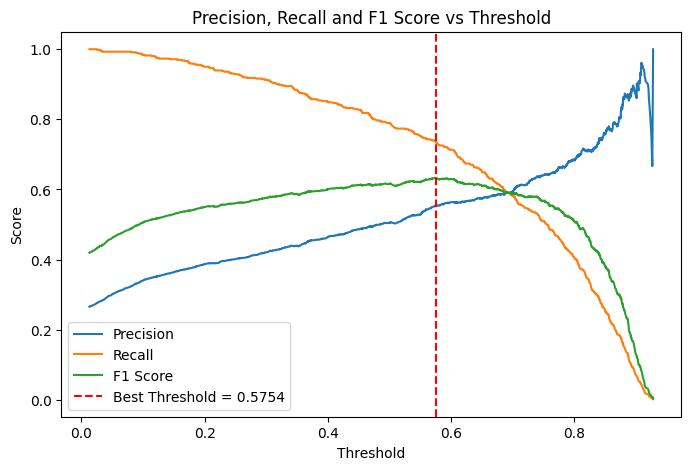

Classification report with best threshold:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1552
           1       0.55      0.74      0.63       561

    accuracy                           0.77      2113
   macro avg       0.72      0.76      0.73      2113
weighted avg       0.80      0.77      0.78      2113

Confusion matrix with best threshold:
[[1220  332]
 [ 147  414]]


In [ ]:
# 1. Obter as probabilidades preditas para a classe positiva
y_prob = model_lr.predict_proba(X_test)[:, 1]

# 2. Calcular precision, recall e thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# 3. Calcular F1 para cada threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# 4. Encontrar o threshold que maximiza o F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold for max F1: {best_threshold:.4f}")
print(f"F1 score at best threshold: {f1_scores[best_idx]:.4f}")

# 5. Plotar precision, recall e f1 versus threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold = {best_threshold:.4f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall and F1 Score vs Threshold")
plt.legend()
plt.show()

# 6. Aplicar o melhor threshold para classificar
y_pred_best = (y_prob >= best_threshold).astype(int)

# 7. Avaliar com o melhor threshold
from sklearn.metrics import classification_report, confusion_matrix

print("Classification report with best threshold:")
print(classification_report(y_test, y_pred_best))

print("Confusion matrix with best threshold:")
print(confusion_matrix(y_test, y_pred_best))


# Modelo LGBM

In [ ]:
# === Pré-processamento
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), var_num),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), var_cat)
])

# === Modelo
model_lgbm =  Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(
            learning_rate=0.1,
            max_depth=4,
            max_iter=40,
            random_state=42,
            min_samples_leaf=200,

    ))
])
#Fit modelo
model_lgbm.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tempo_de_contrato',
                                                   'total_servicos_mes']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['servico_internet',
                                                   'contrato',
                                                   'metodo_pagamento'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_depth=4, max_iter=40,
                                                min_samples_leaf=200,
                                                random_state=42))])

In [ ]:
# === Previsão
y_pred = model_lgbm.predict(X_test)
y_proba = model_lgbm.predict_proba(X_test)[:, 1]

In [ ]:
# === Avaliação
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1552
           1       0.62      0.52      0.57       561

    accuracy                           0.79      2113
   macro avg       0.73      0.70      0.71      2113
weighted avg       0.78      0.79      0.78      2113

Confusion Matrix:
 [[1375  177]
 [ 270  291]]
ROC AUC: 0.8375903899516695


In [ ]:
ks = ks_2samp(y_proba[y_test==1], y_proba[y_test==0]).statistic
print("KS:", round(ks, 4))


KS: 0.5216


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)


In [ ]:
def plot_roc_curve(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    auc_score = roc_auc_score(y_true, y_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


In [ ]:
def plot_ks_curve(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    ks_statistic = max(tpr - fpr)

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, tpr, label='Taxa de Verdadeiros Positivos (TPR)')
    plt.plot(thresholds, fpr, label='Taxa de Falsos Positivos (FPR)')
    plt.plot(thresholds, tpr - fpr, label=f'KS = {ks_statistic:.3f}', color='black', linestyle='--')
    plt.xlabel('Threshold')
    plt.ylabel('Taxa')
    plt.title('Curva KS')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.show()


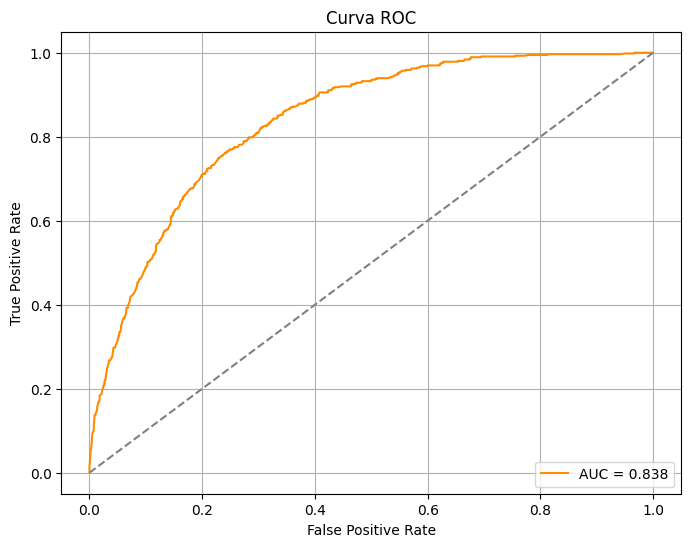

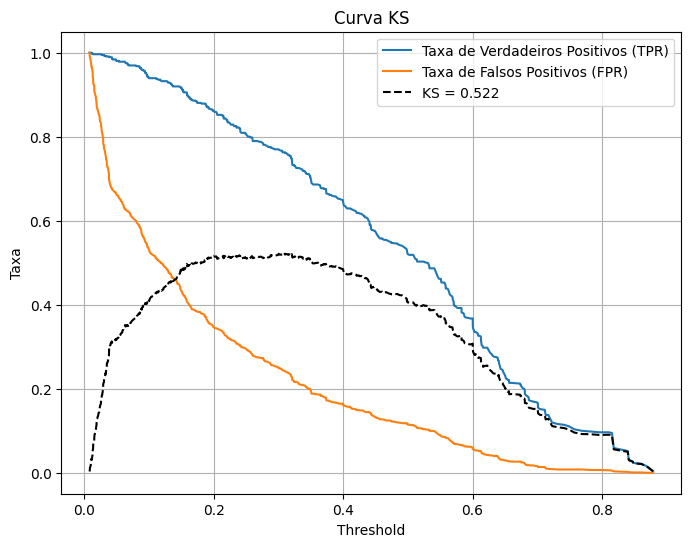

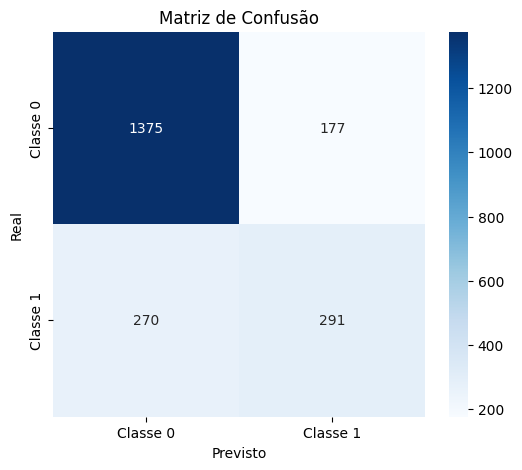

In [ ]:
plot_roc_curve(y_test, y_proba)
plot_ks_curve(y_test, y_proba)
plot_confusion_matrix(y_test, y_pred, labels=["Classe 0", "Classe 1"])


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve
import numpy as np

# Probabilidades preditas
y_proba = model_lgbm.predict_proba(X_test)[:, 1]

# Teste de thresholds para f1-score
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = [f1_score(y_test, y_proba >= t) for t in thresholds]

# Melhor threshold
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Melhor limiar (threshold) para F1-score: {best_threshold:.2f}")


Melhor limiar (threshold) para F1-score: 0.32


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Classificação com o melhor threshold
y_pred_thresh = (y_proba >= best_threshold).astype(int)

# Métricas
print("Classification Report:\n", classification_report(y_test, y_pred_thresh))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.77      0.83      1552
           1       0.54      0.75      0.63       561

    accuracy                           0.77      2113
   macro avg       0.72      0.76      0.73      2113
weighted avg       0.80      0.77      0.78      2113

Confusion Matrix:
 [[1198  354]
 [ 141  420]]
ROC AUC: 0.8375903899516695


In [ ]:
# Transforma os dados com o mesmo preprocessor da pipeline
X_test_transformed = model_lgbm.named_steps['preprocessor'].transform(X_test)

# Recupera os nomes das features após o OneHot + Scaling
feature_names = model_lgbm.named_steps['preprocessor'].get_feature_names_out()

# Convertemos para DataFrame para o SHAP entender os nomes
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)


In [ ]:
import shap

# Cria o TreeExplainer para o modelo ajustado
explainer = shap.Explainer(model_lgbm.named_steps['classifier'])

# Calcula os valores SHAP
shap_values = explainer(X_test_df)


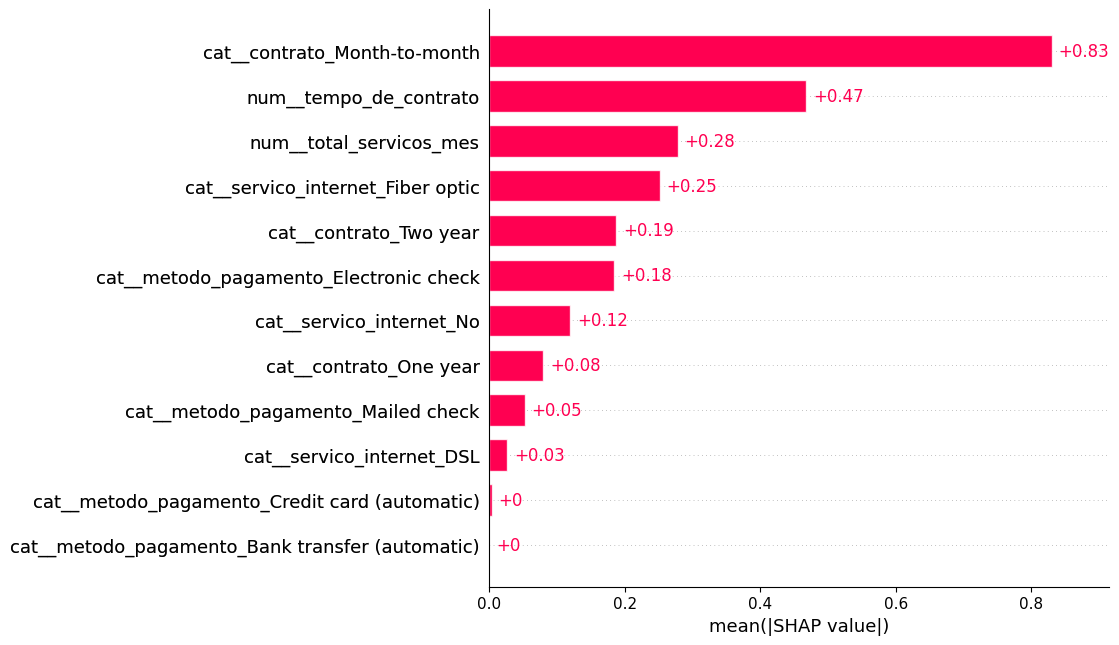

In [ ]:
shap.plots.bar(shap_values, max_display = 20)


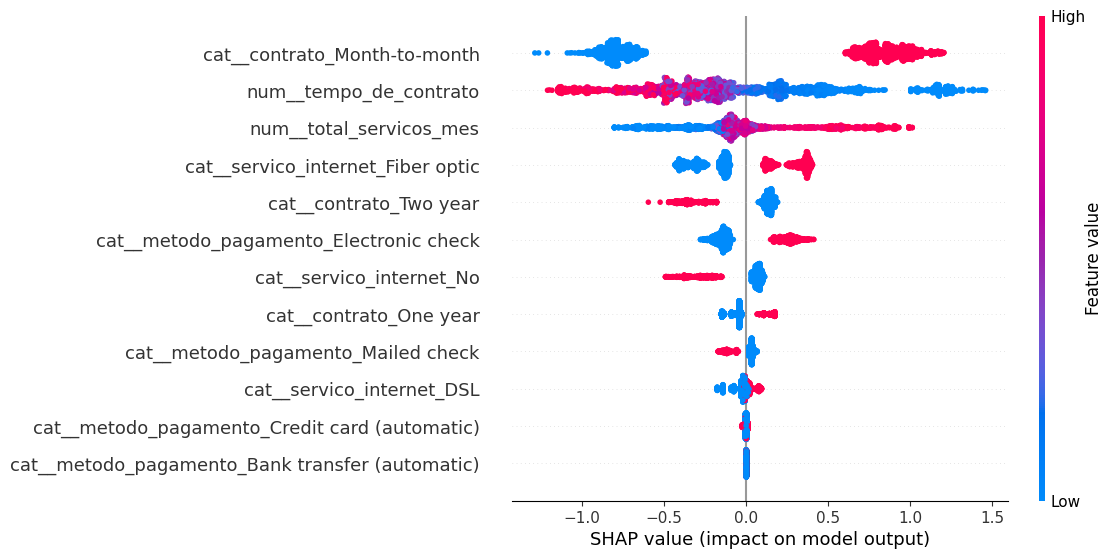

In [ ]:
shap.plots.beeswarm(shap_values, max_display=20)


In [ ]:
feature_names

array(['num__tempo_de_contrato', 'num__total_servicos_mes',
       'cat__servico_internet_DSL', 'cat__servico_internet_Fiber optic',
       'cat__servico_internet_No', 'cat__contrato_Month-to-month',
       'cat__contrato_One year', 'cat__contrato_Two year',
       'cat__metodo_pagamento_Bank transfer (automatic)',
       'cat__metodo_pagamento_Credit card (automatic)',
       'cat__metodo_pagamento_Electronic check',
       'cat__metodo_pagamento_Mailed check'], dtype=object)

#Interpretação features

✅**cat__contrato_Month-to-month**

Ter contrato mensal aumenta a chance de churn.

Não ter contrato mensal ajuda a reduzir o risco.

✅**num__tempo_de_contrato**

Quanto maior o tempo de contrato, menor o risco.

Pouco tempo de contrato aumenta a chance de churn.

✅**cat__servico_internet_Fiber optic**

Ter fibra ótica está relacionado com maior risco.

✅**num__total_servicos_mes**

Quanto mais serviços um cliente utiliza, maior o engajamento com a empresa, o que reduz a chance de churn ou fraude.

✅**cat__contrato_Two year**

Clientes com contratos longos demonstram comprometimento e são menos propensos à churn.

✅**cat__metodo_pagamento_Electronic check**

Esse método pode estar mais presente em clientes menos engajados ou com dificuldades financeiras.

✅**cat__servico_internet_No**

Possivelmente são clientes com menos contato digital, o que pode estar ligado a menor propensão a churn ou uso indevido. Também pode ser um perfil mais antigo/conservador.

✅**cat__contrato_One year**

Clientes com contratos de médio prazo tendem a ser mais estáveis do que os com contrato mensal.

✅**cat__metodo_pagamento_Mailed check**

Esse grupo pode ser composto por clientes tradicionais ou de perfis conservadores, que apresentam comportamento mais previsível.

✅**cat__servico_internet_DSL**

DSL pode indicar um público mais estável ou com menores expectativas de desempenho, menos propenso a churn.

✅**cat__metodo_pagamento_Credit card (automatic)**

Clientes com esse método tendem a ser mais organizados financeiramente e menos propensos ao cancelamento ou inadimplência.

✅**cat__metodo_pagamento_Bank transfer (automatic)**

Indica estabilidade e previsibilidade de pagamento. Clientes com esse tipo de cobrança tendem a permanecer por mais tempo.

# 📊 **Relatório  – Interpretação do Modelo LGBM**

##🎯 **Objetivo do Modelo**
O modelo foi treinado para prever o churn. A análise SHAP mostra quais variáveis mais influenciam a previsão e de que forma.

                    🔝 **Top 5 Features com Maior Impacto**

**cat__contrato_Month**-to-month	▶	Ter contrato mensal aumenta o risco de churn.

**num__tempo_de_contrato**	▶	Quanto maior o tempo, menor o risco.

**cat__servico_internet_Fiber** optic	▶	Clientes com fibra ótica têm maior risco de churn.

**cat__metodo_pagamento_Electronic check**	▶	Usar pagamento por Electronic check está associado a maior risco.

**cat__fatura_sem_papel_Yes**	▶	Clientes com fatura sem papel tendem a ter maior risco também.

                    🧠 **Perfis de Risco Detectados pelo Modelo**

- Cliente em Alto Risco (provável churn/fraude):

- Contrato mensal (Month-to-month)

- Baixo tempo de contrato

- Internet por fibra ótica

- Pagamento por "Electronic check"

- Fatura sem papel ativada

- Cliente em Baixo Risco (tendência de permanência):

- Contrato de 1 ou 2 anos

- Longo tempo de contrato

- Internet via DSL ou sem serviço

- Pagamento por boleto ou transferência bancária

- Fatura impressa


          🧭 **Ações Estratégicas Recomendadas**

**Para retenção de clientes:**

Identificar clientes com contrato mensal + internet por fibra + tempo de contrato baixo.

Então criar campanha para:

Incentivar mudança para contratos anuais.

Oferecer bônus ou desconto para quem imprime fatura ou trocar o método de pagamento.

Melhorar a experiência de clientes com fibra ótica, visto que é um público de alto risco.